In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

os.chdir('/content/drive/My Drive/project/waf/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import json
from pprint import pprint
import pandas as pd
import random

def load_mongo_collection(filename):
    collection = []
    with open(filename) as fd:
        while True:
            line = fd.readline()
            if line:
                data = json.loads(line)
                collection.append(data)
            else:
                break
    
    return collection

attack_log = load_mongo_collection("dataset/csic_attack_log.json") + load_mongo_collection("dataset/modsec_attack_log.json")
normal_log = load_mongo_collection("dataset/my_normal_log.json")
# normal_log = load_mongo_collection("dataset/csic_normal_log.json") + load_mongo_collection("dataset/my_normal_log.json")

# collect all available rules
all_rules = set()
for item in attack_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

for item in normal_log:
    [all_rules.add(x["id"]) for x in item["matched_rules"]]

display(len(all_rules), list(all_rules)[:10])

random.seed(2)
# normal_log = random.sample(normal_log, round(len(attack_log)*5))

print("Len attack_log", len(attack_log))
print("Len normal_log", len(normal_log))

156

[944130,
 943110,
 942100,
 942101,
 921110,
 942110,
 921120,
 942120,
 921130,
 941100]

Len attack_log 23764
Len normal_log 182103


In [3]:
# get all hosts in request headers

hosts = dict()

for item in normal_log:
  host = item["request_headers"]["Host"]
  if host in hosts.keys():
    hosts[host] += 1
  else:
    hosts[host] = 1

sorted_hosts = {k: v for k, v in sorted(hosts.items(), key=lambda item: item[1], reverse=True)}
list(sorted_hosts.items())[:30]

[('mail.google.com', 28644),
 ('www.youtube.com', 22776),
 ('www.google.com', 15535),
 ('static.xx.fbcdn.net', 10072),
 ('www.messenger.com', 9115),
 ('play.google.com', 4947),
 ('beacons.gcp.gvt2.com', 4886),
 ('github.com', 4224),
 ('github.githubassets.com', 1894),
 ('i.ytimg.com', 1818),
 ('calendar.google.com', 1568),
 ('r3---sn-n5pbvoj5caxu8-nbos.googlevideo.com', 1565),
 ('20.client-channel.google.com', 1468),
 ('www.google-analytics.com', 1453),
 ('edge-chat.messenger.com', 1360),
 ('24.client-channel.google.com', 1305),
 ('scontent.fsgn6-1.fna.fbcdn.net', 1280),
 ('content-autofill.googleapis.com', 1176),
 ('27.client-channel.google.com', 1129),
 ('0.client-channel.google.com', 1071),
 ('r1---sn-42u-nbosk.googlevideo.com', 1065),
 ('api.github.com', 1000),
 ('21.client-channel.google.com', 999),
 ('scontent.fsgn6-2.fna.fbcdn.net', 968),
 ('live.github.com', 931),
 ('23.client-channel.google.com', 925),
 ('pm.vzota.com.vn', 898),
 ('ssl.gstatic.com', 838),
 ('miro.medium.com', 

In [4]:
from sklearn.model_selection import train_test_split

def transform_log_item(item):
    global all_rules
    transformed_data = {
        "request_method": item.get("request_method"),
        # "uri": item.get("uri")
    }

    for rule_id in all_rules:
        transformed_data[str(rule_id)] = 0

    for rule_id in map(lambda x: x["id"], item.get("matched_rules")):
        transformed_data[str(rule_id)] = 1

    return transformed_data

cleaned_attack_log = [transform_log_item(x) for x in attack_log]
cleaned_normal_log = [transform_log_item(x) for x in normal_log]

def format_data(logs):
  # convert request_method using one hot encoding
  df = pd.DataFrame(logs)
  temp = pd.get_dummies(df["request_method"], prefix="request_method")
  return pd.concat([df, temp], axis=1).drop(["request_method"], axis=1)


X = format_data(cleaned_attack_log + cleaned_normal_log)
# drop some stupid rule
# 920272, 920273: Validate byte range rules
X = X.drop(columns=['920272', '920273'])

Y = pd.Series([1]*len(cleaned_attack_log) + [0]*len(cleaned_normal_log))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=1, stratify=Y)

display("Train set")
display(pd.concat([X_train.head(), pd.DataFrame({"is_attack": Y_train.head()})], axis=1))
display(Y_train.value_counts())

display("Test set")
display(pd.concat([X_test.head(), pd.DataFrame({"is_attack": Y_test.head()})], axis=1))
display(Y_test.value_counts())

'Train set'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,941101,942130,941110,942140,921150,921151,941120,942150,921160,941130,942160,944210,941140,921180,941150,942180,921190,941160,920170,942190,944240,941170,920180,942200,944250,941180,942210,941190,942220,941200,...,200002,941380,933190,930120,942410,951120,930130,942420,942421,950100,933210,942430,942431,942432,932190,920420,942440,942450,920440,942460,950140,942470,920460,942480,920470,942490,942500,942510,942511,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT,is_attack
150866,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
67871,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
159094,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
78087,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
22169,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1


0    122008
1     15922
dtype: int64

'Test set'

,944130,943110,942100,942101,921110,942110,921120,942120,921130,941100,941101,942130,941110,942140,921150,921151,941120,942150,921160,941130,942160,944210,941140,921180,941150,942180,921190,941160,920170,942190,944240,941170,920180,942200,944250,941180,942210,941190,942220,941200,...,200002,941380,933190,930120,942410,951120,930130,942420,942421,950100,933210,942430,942431,942432,932190,920420,942440,942450,920440,942460,950140,942470,920460,942480,920470,942490,942500,942510,942511,920500,951240,944100,944110,944120,request_method_GET,request_method_HEAD,request_method_OPTIONS,request_method_POST,request_method_PUT,is_attack
149701,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
181445,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
176756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
23974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
22707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


0    60095
1     7842
dtype: int64

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_clf = DecisionTreeClassifier(criterion="entropy", max_depth=20)
# tree_clf = GridSearchCV(tree_clf, {
#     'max_depth': range(25, 35)
# }, cv=5)
tree_clf.fit(X_train, Y_train)

# tree_clf = tree_clf.best_estimator_
display(tree_clf)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

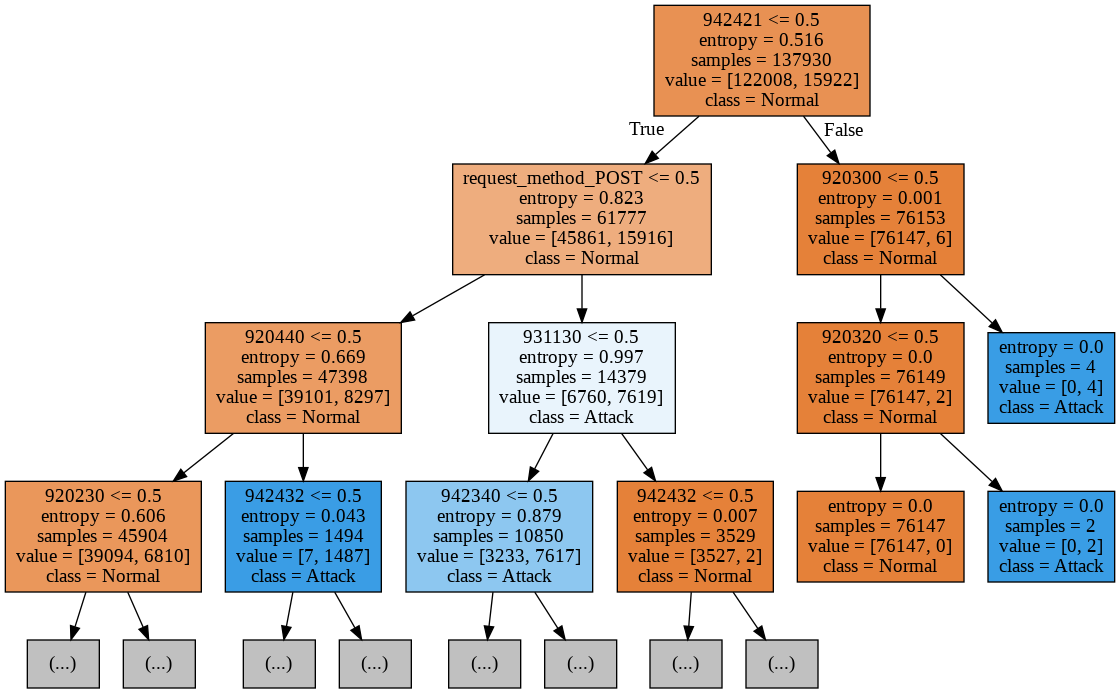

In [6]:
from sklearn.tree import export_graphviz
from subprocess import check_call
from PIL import Image

with open("./images/decision_tree.dot", "w") as fd:
    export_graphviz(tree_clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), max_depth=3, filled=True)

check_call("dot -Tpng ./images/decision_tree.dot -o ./images/decision_tree.png", shell=True)

with open("./images/decision_tree_full.dot", "w") as fd:
    export_graphviz(tree_clf, out_file=fd, feature_names=X_train.columns, class_names=('Normal', 'Attack'), filled=True)

check_call("dot -Tpng ./images/decision_tree_full.dot -o ./images/decision_tree_full.png", shell=True)

img = Image.open("./images/decision_tree.png")
display(img)

In [7]:
train_score = tree_clf.score(X_train, Y_train)
test_score = tree_clf.score(X_test, Y_test)

display(train_score, test_score)

0.9524323932429494

0.9541781356256531

In [8]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(criterion="entropy", max_depth=None, n_estimators=50, n_jobs=-1)
# forest_clf = GridSearchCV(forest_clf, {
#     'max_depth': range(25, 35),
#     'n_estimators': range(85, 95)
# }, cv=5)
forest_clf.fit(X_train, Y_train)
# forest_clf = forest_clf.best_estimator_
print(forest_clf)

forest_train_score =  forest_clf.score(X_train, Y_train)
forest_test_score = forest_clf.score(X_test, Y_test)

display(forest_train_score, forest_test_score)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


0.9526281447110854

0.9542517332234276

array([[59338,   757],
       [ 2356,  5486]])

array([[59332,   763],
       [ 2345,  5497]])

array([[0.98740328, 0.01259672],
       [0.30043356, 0.69956644]])

array([[0.98730344, 0.01269656],
       [0.29903086, 0.70096914]])

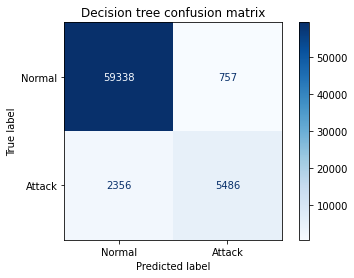

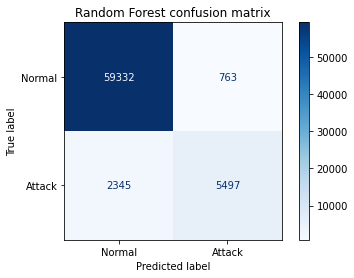

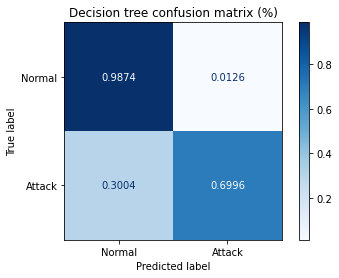

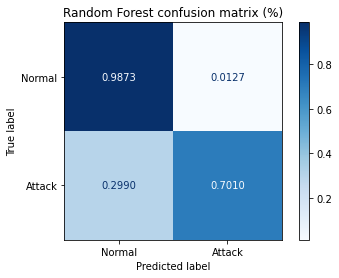

In [9]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

class_names = ['Normal', 'Attack']
plot = plot_confusion_matrix(tree_clf, X_test, Y_test, display_labels=class_names, values_format='d', normalize=None, cmap=plt.cm.Blues)
plot.ax_.set_title('Decision tree confusion matrix')
display(plot.confusion_matrix)

plot = plot_confusion_matrix(forest_clf, X_test, Y_test, display_labels=class_names, values_format='d', normalize=None, cmap=plt.cm.Blues)
plot.ax_.set_title('Random Forest confusion matrix')
display(plot.confusion_matrix)

plot = plot_confusion_matrix(tree_clf, X_test, Y_test, display_labels=class_names, values_format='.4f', normalize='true', cmap=plt.cm.Blues)
plot.ax_.set_title('Decision tree confusion matrix (%)')
display(plot.confusion_matrix)

plot = plot_confusion_matrix(forest_clf, X_test, Y_test, display_labels=class_names, values_format='.4f', normalize='true', cmap=plt.cm.Blues)
plot.ax_.set_title('Random Forest confusion matrix (%)')
display(plot.confusion_matrix)

In [10]:
import pickle

# save decision tree and random forest model
with open("saved-models/decision_tree_model.pickle", "wb") as fd:
    pickle.dump(tree_clf, fd)

with open("saved-models/random_forest_model.pickle", "wb") as fd:
    pickle.dump(forest_clf, fd)

# test
# with open("saved-models/random_forest_model.pickle", "rb") as fd:
#     model = pickle.load(fd)

# display(model.score(X_test, Y_test))

In [11]:
from sklearn.model_selection import cross_val_score
import numpy as np

scores = cross_val_score(tree_clf, X, Y, cv=5)
display("Cross validation score of decision tree: ", np.mean(scores))

scores = cross_val_score(forest_clf, X, Y, cv=5)
display("Cross validation score of random forest: ", np.mean(scores))

'Cross validation score of decision tree: '

0.9478935273618456

'Cross validation score of random forest: '

0.9481995504419954

In [12]:
X_train.columns

Index(['944130', '943110', '942100', '942101', '921110', '942110', '921120',
       '942120', '921130', '941100',
       ...
       '920500', '951240', '944100', '944110', '944120', 'request_method_GET',
       'request_method_HEAD', 'request_method_OPTIONS', 'request_method_POST',
       'request_method_PUT'],
      dtype='object', length=159)

In [13]:
# convert features to lua table

lua_features = "features = {\n"

for feature in X_test.columns:
    lua_features += f"\t'{feature}',\n"
lua_features += "}"

print(lua_features)
print(len(X_test.columns))

features = {
	'944130',
	'943110',
	'942100',
	'942101',
	'921110',
	'942110',
	'921120',
	'942120',
	'921130',
	'941100',
	'941101',
	'942130',
	'941110',
	'942140',
	'921150',
	'921151',
	'941120',
	'942150',
	'921160',
	'941130',
	'942160',
	'944210',
	'941140',
	'921180',
	'941150',
	'942180',
	'921190',
	'941160',
	'920170',
	'942190',
	'944240',
	'941170',
	'920180',
	'942200',
	'944250',
	'941180',
	'942210',
	'941190',
	'942220',
	'941200',
	'942230',
	'941210',
	'920220',
	'942240',
	'941220',
	'920230',
	'942250',
	'942251',
	'944300',
	'941230',
	'920240',
	'942260',
	'941240',
	'942270',
	'941250',
	'920260',
	'942280',
	'941260',
	'920270',
	'920271',
	'920274',
	'942290',
	'934100',
	'941270',
	'942300',
	'941280',
	'942310',
	'941290',
	'920300',
	'933100',
	'942320',
	'941300',
	'933110',
	'933111',
	'942330',
	'911100',
	'941310',
	'920320',
	'933120',
	'932100',
	'942340',
	'941320',
	'932105',
	'933130',
	'933131',
	'932106',
	'932110',
	'942350',
	'941330',
	'932115